# Week 4 - Machine Learning Model Engineering

**Data Used:** week2_data_for_student_lab.csv.gz

In [ ]:
# Install packages
!pip install pyspark
!pip install findspark

In [ ]:
# Set up pyspark
import findspark
findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession.builder \
        .master('local[*]') \
        .appName('Basics') \
        .getOrCreate()

print(spark.version)

3.5.4


In [ ]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
# Read data using pyspark
df_2018_demo = spark.read.csv(f"/content/drive/MyDrive/ TERM 7/MACHINE/churn_prediction/data/week2_data_for_student_lab.csv.gz", inferSchema=True, header=True)
print(f"{df_2018_demo.show(5)}")
df_2018_demo.createOrReplaceTempView("df_2018_demo_view")

+----------------+-----------+--------------------+------+-------+--------+------+-----+---------+-----------+------+-------------+
|transaction_date|member_type|           member_id|gender|product|quantity|amount|  age|card_type|branch_name|region|category_name|
+----------------+-----------+--------------------+------+-------+--------+------+-----+---------+-----------+------+-------------+
|      2018-04-01|     member|ff96777d-cfda-11e...|FEMALE|   3267|      16|  5100|30-35|  REGULAR|    E_Store|     3|  FROZEN FOOD|
|      2018-04-09|     member|00d89024-cfdb-11e...|FEMALE|   6748|       1|  1100|55-60|  REGULAR|    A_Store|     1|          PET|
|      2018-04-01|     member|00858b3b-cfdb-11e...|FEMALE|    420|       4|  5300|55-60|  REGULAR|    A_Store|     1|          PET|
|      2018-04-13|     member|001035ed-cfdb-11e...|FEMALE|   3178|      16|  5600|45-50|  REGULAR|    A_Store|     1|      GADGETS|
|      2018-04-15|     member|ff5fafeb-cfda-11e...|FEMALE|   2727|      19| 

In [ ]:
# Check first 5 rows of data
spark.sql('''
SELECT
  *
FROM
  df_2018_demo_view
LIMIT
  5
''').show()

+----------------+-----------+--------------------+------+-------+--------+------+-----+---------+-----------+------+-------------+
|transaction_date|member_type|           member_id|gender|product|quantity|amount|  age|card_type|branch_name|region|category_name|
+----------------+-----------+--------------------+------+-------+--------+------+-----+---------+-----------+------+-------------+
|      2018-04-01|     member|ff96777d-cfda-11e...|FEMALE|   3267|      16|  5100|30-35|  REGULAR|    E_Store|     3|  FROZEN FOOD|
|      2018-04-09|     member|00d89024-cfdb-11e...|FEMALE|   6748|       1|  1100|55-60|  REGULAR|    A_Store|     1|          PET|
|      2018-04-01|     member|00858b3b-cfdb-11e...|FEMALE|    420|       4|  5300|55-60|  REGULAR|    A_Store|     1|          PET|
|      2018-04-13|     member|001035ed-cfdb-11e...|FEMALE|   3178|      16|  5600|45-50|  REGULAR|    A_Store|     1|      GADGETS|
|      2018-04-15|     member|ff5fafeb-cfda-11e...|FEMALE|   2727|      19| 

In [ ]:
# Count target definition
spark.sql('''
WITH
customer_base AS (
SELECT
  DISTINCT member_id
FROM
  df_2018_demo_view
WHERE
  transaction_date BETWEEN '2018-07-01' AND '2018-07-30'
)
,customer_base_joined_with_past_3_months_txn AS (
SELECT
  a.member_id
  ,b.quantity
  ,b.transaction_date
FROM
  customer_base AS a
LEFT JOIN
  df_2018_demo_view AS b
ON
  a.member_id = b.member_id
AND
  b.transaction_date BETWEEN '2018-04-01' AND '2018-06-30'
)
,customer_base_with_aggregated_total_txns_per_month AS (
SELECT
   member_id
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-04-01' AND '2018-06-30' THEN quantity ELSE 0 END) AS sum_quantity
  ,'2018-06-01' AS partition_month
FROM
  customer_base_joined_with_past_3_months_txn
GROUP BY
  member_id
)
,customers_with_target_definition AS (
SELECT
  *
  ,CASE
    WHEN sum_quantity = 0 THEN 1
    ELSE 0
    END AS target
FROM
  customer_base_with_aggregated_total_txns_per_month
)
,count_customers_with_target_definition AS (
SELECT
  target
  ,COUNT(member_id) AS cnt_member_id
  ,COUNT(DISTINCT member_id) AS cntd_member_id
FROM
  customers_with_target_definition
GROUP BY
  target
)


SELECT
  *
FROM
  count_customers_with_target_definition
''').show()

+------+-------------+--------------+
|target|cnt_member_id|cntd_member_id|
+------+-------------+--------------+
|     1|        15873|         15873|
|     0|        34794|         34794|
+------+-------------+--------------+



In [ ]:
# Show first 5 rows of features for modeling
spark.sql('''
WITH
customer_base AS (
SELECT
  DISTINCT member_id
FROM
  df_2018_demo_view
WHERE
  transaction_date BETWEEN '2018-07-01' AND '2018-07-30'
)
,customer_base_joined_with_past_3_months_txn AS (
SELECT
  a.member_id
  ,b.quantity
  ,b.transaction_date
FROM
  customer_base AS a
LEFT JOIN
  df_2018_demo_view AS b
ON
  a.member_id = b.member_id
AND
  b.transaction_date BETWEEN '2018-04-01' AND '2018-06-30'
)
,customer_base_with_aggregated_total_txns_per_month AS (
SELECT
   member_id
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-04-01' AND '2018-06-30' THEN quantity ELSE 0 END) AS sum_quantity
  ,'2018-06-01' AS partition_date
FROM
  customer_base_joined_with_past_3_months_txn
GROUP BY
  member_id
)
,customers_with_target_definition AS (
SELECT
  *
  ,CASE
    WHEN sum_quantity = 0 THEN 1
    ELSE 0
    END AS target
FROM
  customer_base_with_aggregated_total_txns_per_month
)
,count_customers_with_target_definition AS (
SELECT
  target
  ,COUNT(member_id) AS cnt_member_id
  ,COUNT(DISTINCT member_id) AS cntd_member_id
FROM
  customers_with_target_definition
GROUP BY
  target
)
,customers_joined_with_features AS (
SELECT
  a.member_id
  ,b.quantity
  ,b.amount
  ,b.category_name
  ,b.transaction_date
FROM
  customers_with_target_definition AS a
LEFT JOIN
  df_2018_demo_view AS b
ON
  a.member_id = b.member_id
AND
  b.transaction_date BETWEEN '2018-01-01' AND '2018-03-31'
)
,aggregated_categories AS (
SELECT
   member_id
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('ACCESSORIES') THEN amount ELSE 0 END) AS sum_amount_accessories
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('APPLIANCES') THEN amount ELSE 0 END) AS sum_amount_appliances
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('CLEANERS') THEN amount ELSE 0 END) AS sum_amount_cleaners

  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('CLOTHES') THEN amount ELSE 0 END) AS sum_amount_clothes
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('FOOD') THEN amount ELSE 0 END) AS sum_amount_food
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('FROZEN FOOD') THEN amount ELSE 0 END) AS sum_amount_frozen_food

  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('GADGETS') THEN amount ELSE 0 END) AS sum_amount_gadgets
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('HARDWARE') THEN amount ELSE 0 END) AS sum_amount_hardware
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('PET') THEN amount ELSE 0 END) AS sum_amount_pet

  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('SHOES') THEN amount ELSE 0 END) AS sum_amount_shoes

FROM
  customers_joined_with_features
GROUP BY
  member_id
)
,customers_with_target_joined_with_features AS (
SELECT
  a.member_id
  ,a.target
  ,a.partition_date
  ,b.sum_amount_accessories
  ,b.sum_amount_appliances
  ,b.sum_amount_cleaners
  ,b.sum_amount_clothes
  ,b.sum_amount_food
  ,b.sum_amount_frozen_food
  ,b.sum_amount_gadgets
  ,b.sum_amount_hardware
  ,b.sum_amount_pet
  ,b.sum_amount_shoes
FROM
  customers_with_target_definition AS a
LEFT JOIN
  aggregated_categories AS b
ON
  a.member_id = b.member_id
)

SELECT
  *
FROM
  customers_with_target_joined_with_features LIMIT 5
  --count_customers_with_target_definition
''').show()

+--------------------+------+--------------+----------------------+---------------------+-------------------+------------------+---------------+----------------------+------------------+-------------------+--------------+----------------+
|           member_id|target|partition_date|sum_amount_accessories|sum_amount_appliances|sum_amount_cleaners|sum_amount_clothes|sum_amount_food|sum_amount_frozen_food|sum_amount_gadgets|sum_amount_hardware|sum_amount_pet|sum_amount_shoes|
+--------------------+------+--------------+----------------------+---------------------+-------------------+------------------+---------------+----------------------+------------------+-------------------+--------------+----------------+
|001787f6-cfdb-11e...|     0|    2018-06-01|                     0|                    0|                  0|                 0|              0|                     0|                 0|                  0|             0|               0|
|010ee11a-cfdb-11e...|     0|    2018-06-01|

In [ ]:
# Create modeling ABT (analytics base table)
df_mabt = spark.sql('''
WITH
customer_base AS (
SELECT
  DISTINCT member_id
FROM
  df_2018_demo_view
WHERE
  transaction_date BETWEEN '2018-07-01' AND '2018-07-30'
)
,customer_base_joined_with_past_3_months_txn AS (
SELECT
  a.member_id
  ,b.quantity
  ,b.transaction_date
FROM
  customer_base AS a
LEFT JOIN
  df_2018_demo_view AS b
ON
  a.member_id = b.member_id
AND
  b.transaction_date BETWEEN '2018-04-01' AND '2018-06-30'
)
,customer_base_with_aggregated_total_txns_per_month AS (
SELECT
   member_id
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-04-01' AND '2018-06-30' THEN quantity ELSE 0 END) AS sum_quantity
  ,'2018-07-01' AS partition_date
FROM
  customer_base_joined_with_past_3_months_txn
GROUP BY
  member_id
)
,customers_with_target_definition AS (
SELECT
  *
  ,CASE
    WHEN sum_quantity = 0 THEN 1
    ELSE 0
    END AS target
FROM
  customer_base_with_aggregated_total_txns_per_month
)
,count_customers_with_target_definition AS (
SELECT
  target
  ,COUNT(member_id) AS cnt_member_id
  ,COUNT(DISTINCT member_id) AS cntd_member_id
FROM
  customers_with_target_definition
GROUP BY
  target
)
,customers_joined_with_features AS (
SELECT
  a.member_id
  ,b.quantity
  ,b.amount
  ,b.category_name
  ,b.transaction_date
FROM
  customers_with_target_definition AS a
LEFT JOIN
  df_2018_demo_view AS b
ON
  a.member_id = b.member_id
AND
  b.transaction_date BETWEEN '2018-01-01' AND '2018-03-31'
)
,aggregated_categories AS (
SELECT
   member_id
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('ACCESSORIES') THEN amount ELSE 0 END) AS sum_amount_accessories
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('APPLIANCES') THEN amount ELSE 0 END) AS sum_amount_appliances
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('CLEANERS') THEN amount ELSE 0 END) AS sum_amount_cleaners

  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('CLOTHES') THEN amount ELSE 0 END) AS sum_amount_clothes
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('FOOD') THEN amount ELSE 0 END) AS sum_amount_food
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('FROZEN FOOD') THEN amount ELSE 0 END) AS sum_amount_frozen_food

  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('GADGETS') THEN amount ELSE 0 END) AS sum_amount_gadgets
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('HARDWARE') THEN amount ELSE 0 END) AS sum_amount_hardware
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('PET') THEN amount ELSE 0 END) AS sum_amount_pet

  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('SHOES') THEN amount ELSE 0 END) AS sum_amount_shoes

FROM
  customers_joined_with_features
GROUP BY
  member_id
)
,customers_with_target_joined_with_features AS (
SELECT
  a.member_id
  ,a.target
  ,b.sum_amount_accessories
  ,b.sum_amount_appliances
  ,b.sum_amount_cleaners
  ,b.sum_amount_clothes
  ,b.sum_amount_food
  ,b.sum_amount_frozen_food
  ,b.sum_amount_gadgets
  ,b.sum_amount_hardware
  ,b.sum_amount_pet
  ,b.sum_amount_shoes
  ,a.partition_date
FROM
  customers_with_target_definition AS a
LEFT JOIN
  aggregated_categories AS b
ON
  a.member_id = b.member_id
)

SELECT
  *
FROM
  customers_with_target_joined_with_features
  --LIMIT 5
  --count_customers_with_target_definition
''')
df_mabt.createOrReplaceTempView("df_mabt_view")

In [ ]:
# Save modeling ABT as pandas
pdf_mabt = df_mabt.toPandas()
pdf_mabt.head()

,member_id,target,sum_amount_accessories,sum_amount_appliances,sum_amount_cleaners,sum_amount_clothes,sum_amount_food,sum_amount_frozen_food,sum_amount_gadgets,sum_amount_hardware,sum_amount_pet,sum_amount_shoes,partition_date
0,00000864-cfdb-11eb-9633-d8f2ca37414f,0,0,0,0,0,0,0,0,0,0,0,2018-07-01
1,00000867-cfdb-11eb-80ce-d8f2ca37414f,1,3600,0,0,0,0,9400,3200,0,15000,9900,2018-07-01
2,0000086b-cfdb-11eb-81cf-d8f2ca37414f,0,0,0,0,0,0,0,0,0,0,0,2018-07-01
3,0000087b-cfdb-11eb-ab7f-d8f2ca37414f,0,5400,0,9100,0,0,0,0,0,5300,0,2018-07-01
4,00000880-cfdb-11eb-8d6f-d8f2ca37414f,0,0,0,0,0,0,0,0,0,10600,4600,2018-07-01


In [ ]:
# Check column names in data
pdf_mabt.columns

Index(['member_id', 'target', 'sum_amount_accessories',
       'sum_amount_appliances', 'sum_amount_cleaners', 'sum_amount_clothes',
       'sum_amount_food', 'sum_amount_frozen_food', 'sum_amount_gadgets',
       'sum_amount_hardware', 'sum_amount_pet', 'sum_amount_shoes',
       'partition_date'],
      dtype='object')

In [ ]:
# Check summary statistics
pdf_mabt[['sum_amount_accessories',
       'sum_amount_appliances', 'sum_amount_cleaners', 'sum_amount_clothes',
       'sum_amount_food', 'sum_amount_frozen_food', 'sum_amount_gadgets',
       'sum_amount_hardware', 'sum_amount_pet', 'sum_amount_shoes']].describe().T

,count,mean,std,min,25%,50%,75%,max
sum_amount_accessories,50667.0,433.001757,1771.769079,0.0,0.0,0.0,0.0,27800.0
sum_amount_appliances,50667.0,391.529003,1646.328998,0.0,0.0,0.0,0.0,23900.0
sum_amount_cleaners,50667.0,2537.906330,5845.770163,0.0,0.0,0.0,0.0,71000.0
sum_amount_clothes,50667.0,442.706298,1805.479190,0.0,0.0,0.0,0.0,23000.0
sum_amount_food,50667.0,401.170387,1707.918547,0.0,0.0,0.0,0.0,22400.0
sum_amount_frozen_food,50667.0,448.487181,1793.683305,0.0,0.0,0.0,0.0,34600.0
sum_amount_gadgets,50667.0,418.440010,1738.975410,0.0,0.0,0.0,0.0,27500.0
sum_amount_hardware,50667.0,410.865060,1717.823263,0.0,0.0,0.0,0.0,24000.0
sum_amount_pet,50667.0,2352.296366,4988.124531,0.0,0.0,0.0,3300.0,60400.0
sum_amount_shoes,50667.0,391.580319,1663.879980,0.0,0.0,0.0,0.0,26400.0


In [ ]:
# Check summary statistics per target definition
pdf_mabt.groupby(['target'])[['sum_amount_accessories',
       'sum_amount_appliances', 'sum_amount_cleaners', 'sum_amount_clothes',
       'sum_amount_food', 'sum_amount_frozen_food', 'sum_amount_gadgets',
       'sum_amount_hardware', 'sum_amount_pet', 'sum_amount_shoes']].describe().T

target                                   0             1
sum_amount_accessories count  34794.000000  15873.000000
                       mean     433.557510    431.783532
                       std     1781.755727   1749.733836
                       min        0.000000      0.000000
                       25%        0.000000      0.000000
                       50%        0.000000      0.000000
                       75%        0.000000      0.000000
                       max    27800.000000  21100.000000
sum_amount_appliances  count  34794.000000  15873.000000
                       mean     395.686038    382.416682
                       std     1658.075562   1620.296825
                       min        0.000000      0.000000
                       25%        0.000000      0.000000
                       50%        0.000000      0.000000
                       75%        0.000000      0.000000
                       max    23900.000000  22500.000000
sum_amount_cleaners    count  34794.000000  15873.000000
                       mean    2526.153935   2563.667864
                       std     5821.540145   5898.637125
                       min        0.000000      0.000000
                       25%        0.000000      0.000000
                       50%        0.000000      0.000000
                       75%        0.000000      0.000000
                       max    71000.000000  63900.000000
sum_amount_clothes     count  34794.000000  15873.000000
                       mean     438.265218    452.441252
                       std     1798.786813   1820.081957
                       min        0.000000      0.000000
                       25%        0.000000      0.000000
                       50%        0.000000      0.000000
                       75%        0.000000      0.000000
                       max    23000.000000  17700.000000
sum_amount_food        count  34794.000000  15873.000000
                       mean     392.846468    419.416619
                       std     1689.032908   1748.518162
                       min        0.000000      0.000000
                       25%        0.000000      0.000000
                       50%        0.000000      0.000000
                       75%        0.000000      0.000000
                       max    22400.000000  20100.000000
sum_amount_frozen_food count  34794.000000  15873.000000
                       mean     448.652066    448.125748
                       std     1795.244213   1790.313436
                       min        0.000000      0.000000
                       25%        0.000000      0.000000
                       50%        0.000000      0.000000
                       75%        0.000000      0.000000
                       max    24800.000000  34600.000000
sum_amount_gadgets     count  34794.000000  15873.000000
                       mean     416.798873    422.037422
                       std     1740.617205   1735.420462
                       min        0.000000      0.000000
                       25%        0.000000      0.000000
                       50%        0.000000      0.000000
                       75%        0.000000      0.000000
                       max    27500.000000  18400.000000
sum_amount_hardware    count  34794.000000  15873.000000
                       mean     412.148646    408.051408
                       std     1722.759832   1707.002947
                       min        0.000000      0.000000
                       25%        0.000000      0.000000
                       50%        0.000000      0.000000
                       75%        0.000000      0.000000
                       max    24000.000000  21700.000000
sum_amount_pet         count  34794.000000  15873.000000
                       mean    2364.591596   2325.344925
                       std     5019.944634   4917.703229
                       min        0.000000      0.000000
                       25%        0.000000      0.000000
          

In [ ]:
# Copy data for modeling
data = pdf_mabt[['target', 'sum_amount_accessories',
       'sum_amount_appliances', 'sum_amount_cleaners', 'sum_amount_clothes',
       'sum_amount_food', 'sum_amount_frozen_food', 'sum_amount_gadgets',
       'sum_amount_hardware', 'sum_amount_pet', 'sum_amount_shoes',
       ]].copy()

In [ ]:
# Separate target variable and features
y = data['target']
X = data.drop(['target'], axis=1)

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Model
estimator = LogisticRegression()

# Create transformers for categorical and numeric features
preprocessor = ColumnTransformer(
    transformers=[
        #('cat_onehot', OneHotEncoder(handle_unknown='ignore'), [])
        #,
         ('num_standard', StandardScaler(), ['sum_amount_accessories',
       'sum_amount_appliances', 'sum_amount_cleaners', 'sum_amount_clothes',
       'sum_amount_food', 'sum_amount_frozen_food', 'sum_amount_gadgets',
       'sum_amount_hardware', 'sum_amount_pet', 'sum_amount_shoes'])
        #,('num_minmax', MinMaxScaler(), [])
    ],
    remainder='passthrough',
)

# Create a logistic regression model using a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor)
    ,('estimator', estimator)
])

# Fit training data into model pipeline
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_standard',
                                                  StandardScaler(),
                                                  ['sum_amount_accessories',
                                                   'sum_amount_appliances',
                                                   'sum_amount_cleaners',
                                                   'sum_amount_clothes',
                                                   'sum_amount_food',
                                                   'sum_amount_frozen_food',
                                                   'sum_amount_gadgets',
                                                   'sum_amount_hardware',
                                                   'sum_amount_pet',
                                                   'sum_amount_shoes'])])),
                ('estimator', LogisticRegression())])

Accuracy: 0.69
Precision: 0.00
Recall: 0.00

Confusion Matrix:
[[27863     0]
 [12670     0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


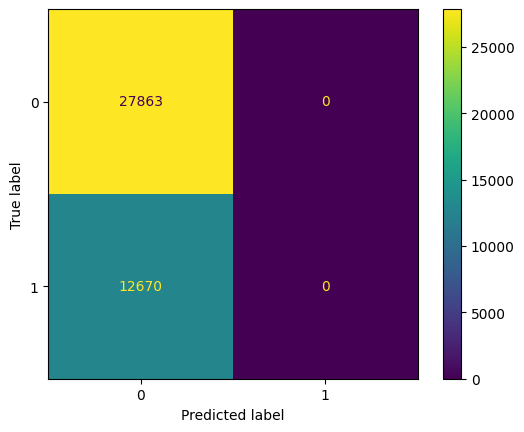

In [ ]:
# Make predictions on the train set
y_pred_train = pipeline.predict(X_train)

# Evaluate the model
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train)
recall_train = recall_score(y_train, y_pred_train)
cm_train = confusion_matrix(y_train, y_pred_train)

print(f"Accuracy: {accuracy_train:.2f}")
print(f"Precision: {precision_train:.2f}")
print(f"Recall: {recall_train:.2f}")
print(f"\nConfusion Matrix:")
print(cm_train)

cmd_train = ConfusionMatrixDisplay(cm_train)
cmd_train.plot()

Accuracy: 0.68
Precision: 0.00
Recall: 0.00

Confusion Matrix:
[[6931    0]
 [3203    0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


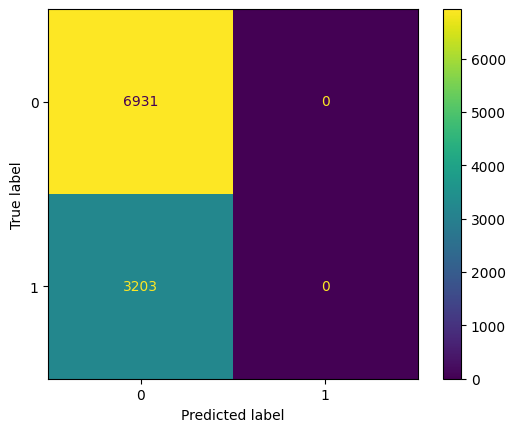

In [ ]:
# Make predictions on the test set
y_pred_test = pipeline.predict(X_test)

# Evaluate the model
accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
cm_test = confusion_matrix(y_test, y_pred_test)

print(f"Accuracy: {accuracy_test:.2f}")
print(f"Precision: {precision_test:.2f}")
print(f"Recall: {recall_test:.2f}")
print(f"\nConfusion Matrix:")
print(cm_test)

cmd_test = ConfusionMatrixDisplay(cm_test)
cmd_test.plot()

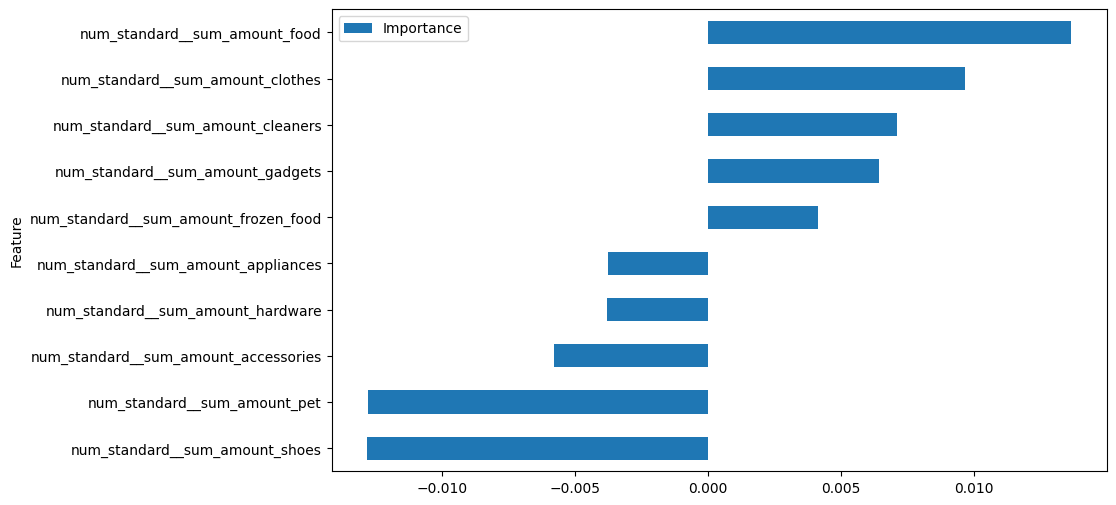

Intercept: -0.7882015726598848


In [ ]:
#### Get coefficients & intercept

coefficients = pipeline.named_steps.estimator.coef_[0]
feature_names = pipeline.named_steps.preprocessor.get_feature_names_out()

feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': coefficients})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
plt.show()

intercept = pipeline.named_steps.estimator.intercept_[0]
print(f'Intercept: {intercept}')

# Observation and Analysis

Based on my observation and analysis from this week's notebook, the machine learning pipeline uses logistic regression to forecast customer turnover based on aggregated purchase amounts across product categories. Feature scaling is accomplished using the 'StandardScaler', however no category feature encoding is used. Model evaluation reveals a significant issue: although reaching approximately 69% accuracy, both precision and recall are zero, indicating that the model fails to correctly forecast any churn cases.

The confusion matrices show that the model predicts only the majority class (non-churners), resulting in high accuracy but poor performance on actual churn prediction. This shows a class imbalance, which may necessitate strategies such as oversampling, undersampling, or class-weight adjustment to increase forecast accuracy. The feature importance plot shows the model's reliance on specific buying habits, however its effectiveness is currently limited by the imbalance issue.